# XGBoost underwriting model with SHAP explanations

This notebook trains a multiclass XGBoost model to predict the underwriting decision (accept / accept_with_premium / needs_more_info / reject) from applicant attributes in the simulated dataset, and then uses SHAP to explain feature impacts.

Notes:
- We deliberately exclude 'risk_score' and 'underwriter_score' as features so the model learns from the raw attributes, not the constructed scores.
- Target is the categorical 'underwriter_decision'.

In [2]:
# Imports and setup
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='notebook')

# Enable JS for SHAP plots in Jupyter environments
try:
    shap.initjs()
except Exception:
    pass

c:\Users\mikej\OneDrive\Privat\Allgemein\HackathonBasel2025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset
from pathlib import Path
try:
    nb_dir = Path(__file__).parent
except NameError:
    # __file__ is not defined in Jupyter; fall back to current working directory
    nb_dir = Path.cwd()
DATA_PATH = nb_dir / 'synthetic_life_insurance_10000.json'
print('Loading from:', DATA_PATH)
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.DataFrame(data)
print(f'Data shape: {df.shape}')
df.head(3)


Loading from: c:\Users\mikej\OneDrive\Privat\Allgemein\HackathonBasel2025\baselhacks_pax\datageneration\synthetic_life_insurance_10000.json
Data shape: (10000, 29)
Data shape: (10000, 29)


,gender,age,marital_status,height_cm,weight_kg,bmi,smoking,packs_per_week,drug_use,drug_frequency,...,regular_medication,medication_type,sports_activity_h_per_week,earning_chf,application_year,risk_multiplier,risk_score,underwriter_score,underwriter_decision,premium_loading
0,m,21,divorced,170.2,80.2,27.7,True,0,False,0.0,...,False,warning,0,228916,2006,0.862138,0.100210,0.1003,accept_with_premium,0.1
1,f,61,divorced,184.0,114.5,33.8,False,0,True,4.3,...,False,warning,9,80407,2010,3.148462,0.809681,0.9773,reject,0.0
2,m,23,married,174.2,92.3,30.4,False,0,False,0.0,...,False,safe,6,100765,2010,1.052512,0.201020,0.1835,accept_with_premium,0.6


In [4]:
# Define features and target
target_col = 'underwriter_decision'
# Exclude fields that leak policy or are outcomes/constructed scores
exclude_cols = {
    target_col, 'underwriter_score', 'risk_score', 'risk_multiplier',
    'premium_loading', 'application_year'
}
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Separate numeric and categorical
numeric_cols = [
    'age', 'height_cm', 'weight_kg', 'bmi', 'packs_per_week',
    'drug_frequency', 'sports_activity_h_per_week', 'earning_chf'
]
categorical_cols = [c for c in feature_cols if c not in numeric_cols]
print('Num features:', len(feature_cols))
print(' - numeric:', len(numeric_cols), '| categorical:', len(categorical_cols))

X = df[feature_cols].copy()
y = df[target_col].astype(str).values

# Label-encode the target for XGBoost multiclass
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = list(le.classes_)
n_classes = len(class_names)
class_names

Num features: 23
 - numeric: 8 | categorical: 15


['accept', 'accept_with_premium', 'needs_more_info', 'reject']

In [5]:
# Train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Preprocess: OneHot for categoricals, keep numerics
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
pre = ColumnTransformer(
    transformers=[('cat', ohe, categorical_cols)],
    remainder='passthrough'
)

# Fit transformer and transform splits
X_train_t = pre.fit_transform(X_train)
X_valid_t = pre.transform(X_valid)
X_test_t  = pre.transform(X_test)

# Feature names after OHE
ohe_feat_names = pre.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feat_names = list(ohe_feat_names) + numeric_cols
len(feat_names), feat_names[:10]


(46,
 ['gender_f',
  'gender_m',
  'marital_status_divorced',
  'marital_status_married',
  'marital_status_single',
  'marital_status_widowed',
  'smoking_False',
  'smoking_True',
  'drug_use_False',
  'drug_use_True'])

Accuracy: 0.880

Classification report:
                     precision    recall  f1-score   support

             accept       0.86      0.90      0.88       205
accept_with_premium       0.77      0.79      0.78       310
    needs_more_info       0.57      0.43      0.49       204
             reject       0.95      0.97      0.96      1281

           accuracy                           0.88      2000
          macro avg       0.79      0.77      0.78      2000
       weighted avg       0.87      0.88      0.87      2000



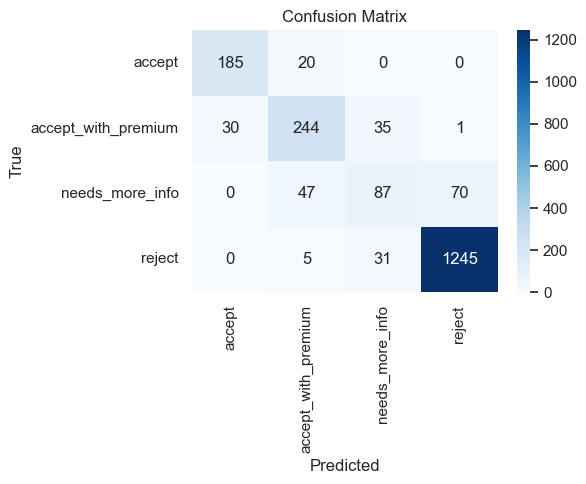

In [6]:
# XGBoost multiclass model
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=n_classes,
    eval_metric='mlogloss',
    tree_method='hist',
    random_state=42
)

# Fit without early stopping for broad version compatibility
xgb_model.fit(X_train_t, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test_t)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.3f}')
print('\nClassification report:')
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


PermutationExplainer explainer: 1001it [04:54,  3.39it/s]                          



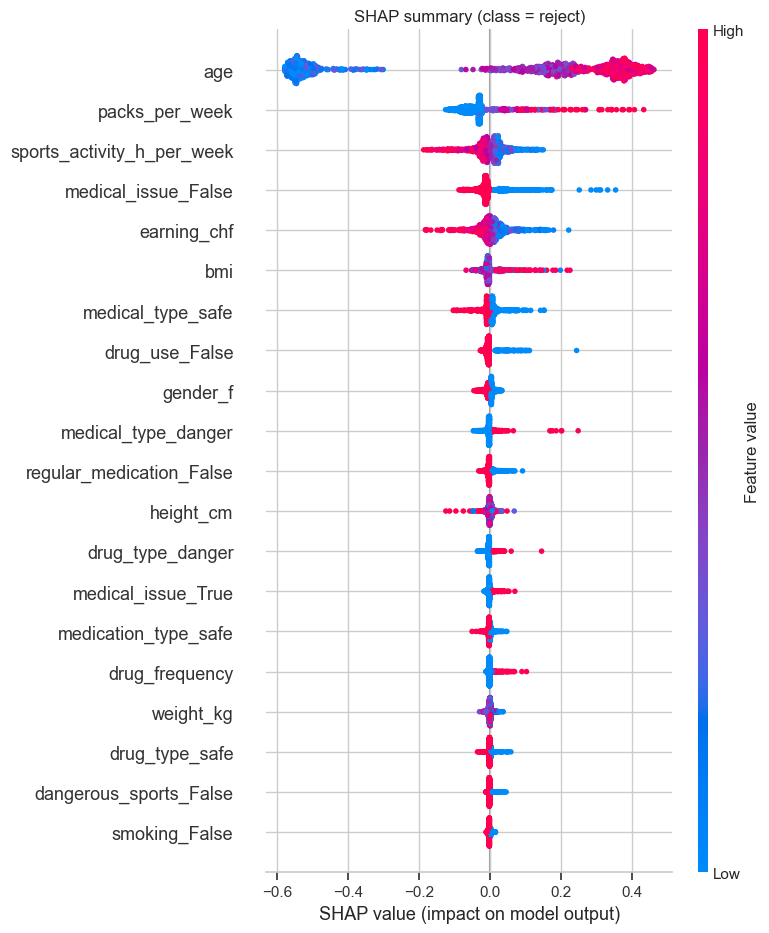

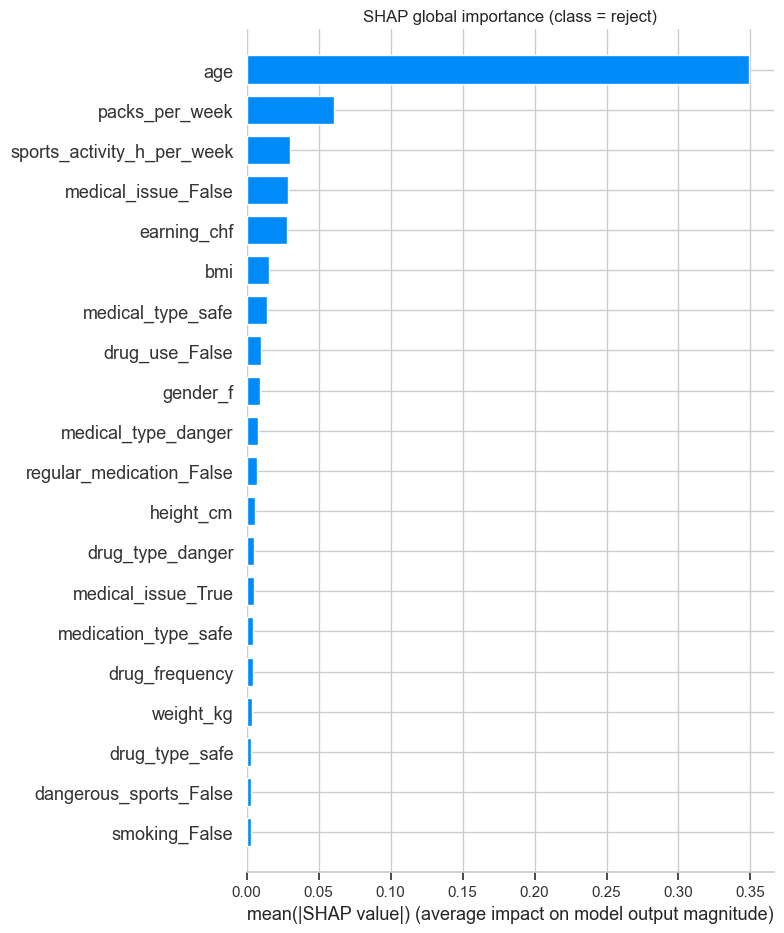

In [7]:
# SHAP explanations
# We'll explain a sample to keep it fast.
sample_size = min(1000, X_test_t.shape[0])
idx = np.random.RandomState(42).choice(X_test_t.shape[0], size=sample_size, replace=False)
X_explain = X_test_t[idx]

# Use model.predict_proba with generic Explainer for compatibility across versions
explainer = shap.Explainer(xgb_model.predict_proba, X_train_t)
shap_values = explainer(X_explain)

# For multiclass, shap_values values are (n, features, classes)
try:
    cls_idx = class_names.index('reject')
except ValueError:
    cls_idx = 0

values = getattr(shap_values, 'values', shap_values)
if values.ndim == 3:
    sv = values[:, :, cls_idx]
else:
    sv = values  # binary or single-output

# Beeswarm summary plot for the chosen class
plt.figure(figsize=(9,6))
shap.summary_plot(sv, features=X_explain, feature_names=feat_names, show=False)
plt.title(f'SHAP summary (class = {class_names[cls_idx]})')
plt.tight_layout()
plt.show()

# Bar summary (global importance)
plt.figure(figsize=(9,6))
shap.summary_plot(sv, features=X_explain, feature_names=feat_names, plot_type='bar', show=False)
plt.title(f'SHAP global importance (class = {class_names[cls_idx]})')
plt.tight_layout()
plt.show()


### Notes
- One-hot expanded features are used for SHAP, so categorical levels appear as separate binary features.
- For different perspectives, change `cls_idx` to another class label from `class_names`.
- If you prefer a regression target (e.g., predict `underwriter_score`), switch the target accordingly and use `XGBRegressor` with SHAP the same way.

## What is a SHAP waterfall plot?

A waterfall plot explains one single prediction by showing how the model moves from the baseline (expected value) to the final output.
Each feature’s SHAP value is a step: positive pushes the prediction up (towards the class), negative pushes it down.
It’s great for case-by-case underwriting reviews, because it tells you exactly which attributes drove the decision and by how much.

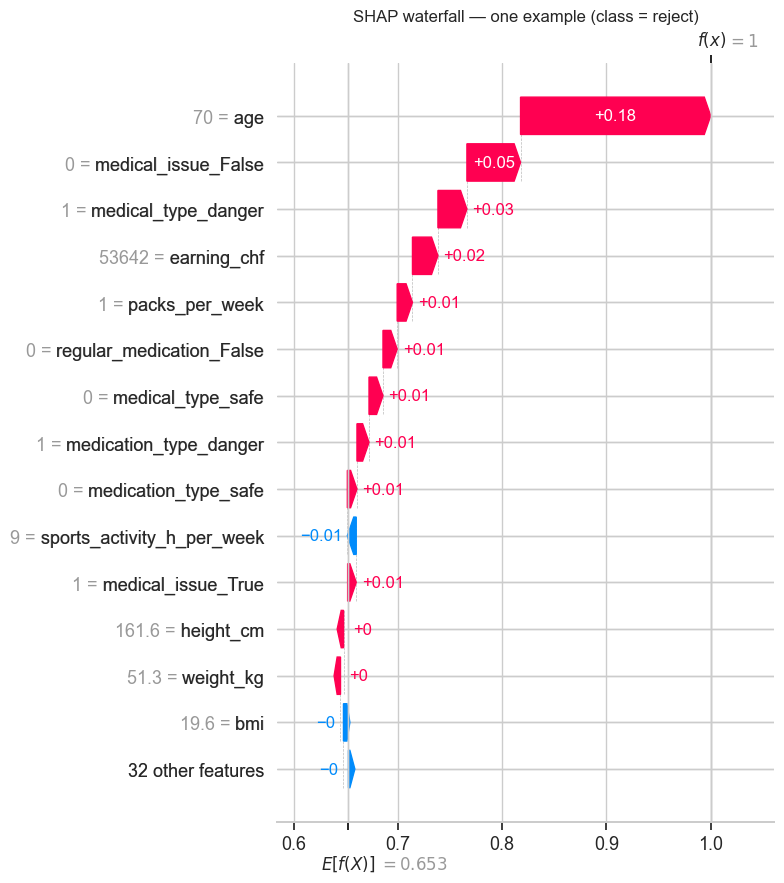

In [8]:
# Waterfall plot for a single example (class-level explanation)
# Choose a class of interest (prefer 'reject' if present)
try:
    cls_name = 'reject' if 'reject' in class_names else class_names[0]
    cls_idx = class_names.index(cls_name)
except Exception:
    cls_idx = 0
    cls_name = class_names[0]

# Pick an example with high predicted probability for this class
probs = xgb_model.predict_proba(X_explain)  # uses the same sample used for SHAP above
pick = int(np.argmax(probs[:, cls_idx]))
x_one = X_explain[pick]

# Build a single-example SHAP Explanation with feature names
base_vals = getattr(shap_values, 'base_values', None)
if isinstance(base_vals, np.ndarray) and base_vals.ndim == 2:
    base_val = float(base_vals[pick, cls_idx])
elif isinstance(base_vals, np.ndarray) and base_vals.ndim == 1:
    base_val = float(base_vals[pick])
else:
    base_val = 0.0

vals = getattr(shap_values, 'values', shap_values)
if isinstance(vals, np.ndarray) and vals.ndim == 3:
    contrib = vals[pick, :, cls_idx]
else:
    contrib = vals[pick]

exp_one = shap.Explanation(values=contrib, base_values=base_val, data=x_one, feature_names=feat_names)

# Plot waterfall (top features shown)
plt.figure(figsize=(9,7))
shap.plots.waterfall(exp_one, max_display=15, show=False)
plt.title(f"SHAP waterfall — one example (class = {cls_name})")
plt.tight_layout()
plt.show()


## Focus on class: needs_more_info (accepted but needs clarification)

We’ll inspect how confident the model is for this class across the test set, then pick a representative case around the median confidence for a detailed waterfall explanation.

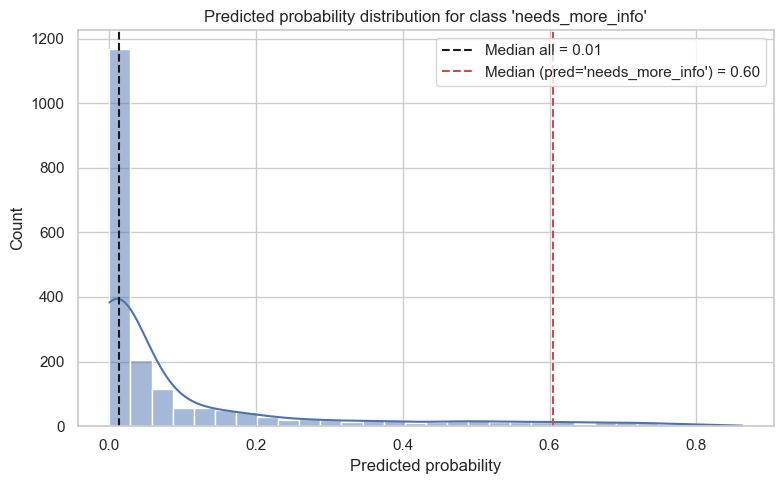

Share of test samples predicted as 'needs_more_info': 0.076


In [9]:
# Distribution of predicted probabilities for class 'needs_more_info'
focus_cls = 'needs_more_info'
try:
    focus_idx = class_names.index(focus_cls)
except ValueError:
    focus_idx = 0

probs_all = xgb_model.predict_proba(X_test_t)
preds_idx = probs_all.argmax(axis=1)
probs_focus = probs_all[:, focus_idx]

median_all = float(np.median(probs_focus))
mask_pred_focus = preds_idx == focus_idx
frac_pred_focus = float(mask_pred_focus.mean())
median_pred_focus = float(np.median(probs_focus[mask_pred_focus])) if mask_pred_focus.any() else float('nan')

plt.figure(figsize=(8,5))
sns.histplot(probs_focus, bins=30, kde=True)
plt.axvline(median_all, color='k', linestyle='--', label=f'Median all = {median_all:.2f}')
if mask_pred_focus.any():
    plt.axvline(median_pred_focus, color='r', linestyle='--', label=f"Median (pred='{focus_cls}') = {median_pred_focus:.2f}")
plt.title(f"Predicted probability distribution for class '{focus_cls}'")
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Share of test samples predicted as '{focus_cls}': {frac_pred_focus:.3f}")


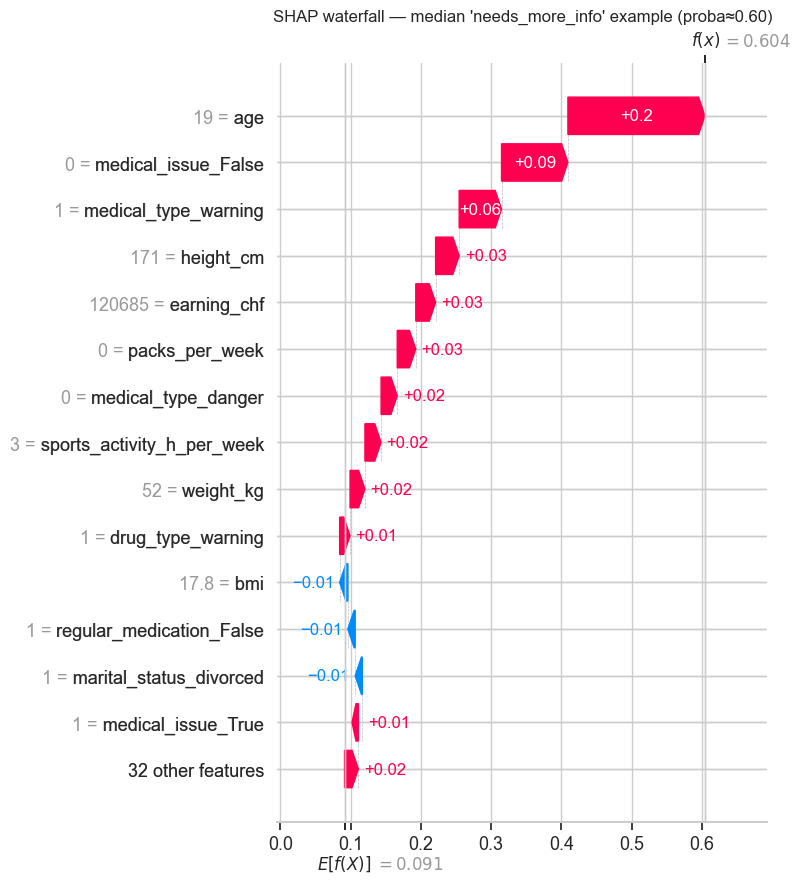

In [10]:
# Waterfall for a 'needs_more_info' example near median confidence
focus_cls = 'needs_more_info'
try:
    focus_idx = class_names.index(focus_cls)
except ValueError:
    focus_idx = 0
    focus_cls = class_names[0]

probs_all = xgb_model.predict_proba(X_test_t)
preds_idx = probs_all.argmax(axis=1)
mask_pred_focus = preds_idx == focus_idx

if mask_pred_focus.any():
    cand_idx = np.where(mask_pred_focus)[0]
    cand_probs = probs_all[cand_idx, focus_idx]
    target = np.median(cand_probs)
    pick_rel = int(np.argmin(np.abs(cand_probs - target)))
    pick = int(cand_idx[pick_rel])
else:
    # fallback: pick the overall median probability example
    target = np.median(probs_all[:, focus_idx])
    pick = int(np.argmin(np.abs(probs_all[:, focus_idx] - target)))

# Compute SHAP for this single example
shap_one = explainer(X_test_t[[pick]])
base_vals = getattr(shap_one, 'base_values', None)
if isinstance(base_vals, np.ndarray) and base_vals.ndim == 2:
    base_val = float(base_vals[0, focus_idx])
elif isinstance(base_vals, np.ndarray) and base_vals.ndim == 1:
    base_val = float(base_vals[0])
else:
    base_val = 0.0

vals = getattr(shap_one, 'values', shap_one)
if isinstance(vals, np.ndarray) and vals.ndim == 3:
    contrib = vals[0, :, focus_idx]
elif isinstance(vals, np.ndarray) and vals.ndim == 2:
    contrib = vals[0]
else:
    contrib = np.array(vals).reshape(-1)

x_one = X_test_t[pick]
exp_mid = shap.Explanation(values=contrib, base_values=base_val, data=x_one, feature_names=feat_names)

plt.figure(figsize=(9,7))
shap.plots.waterfall(exp_mid, max_display=15, show=False)
plt.title(f"SHAP waterfall — median '{focus_cls}' example (proba≈{probs_all[pick, focus_idx]:.2f})")
plt.tight_layout()
plt.show()


## Focus on class: accept

We’ll look at the predicted probability distribution for the 'accept' class and then explain a representative individual near the median confidence with a SHAP waterfall plot.

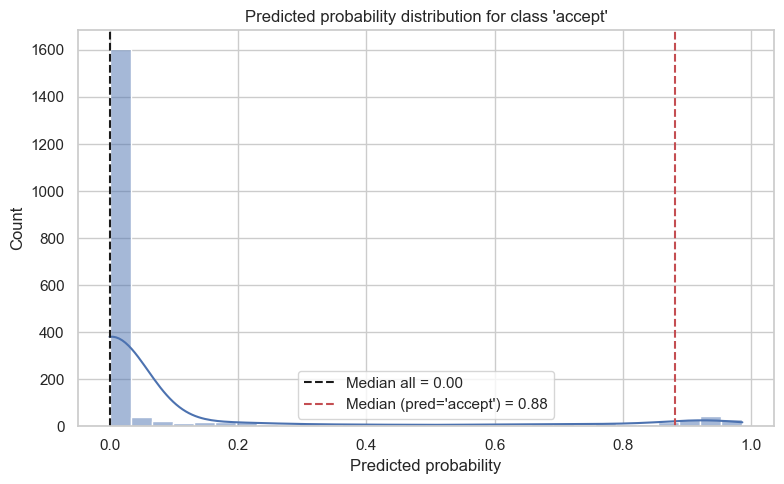

Share of test samples predicted as 'accept': 0.107


In [11]:
# Distribution of predicted probabilities for class 'accept'
focus_cls = 'accept'
try:
    focus_idx = class_names.index(focus_cls)
except ValueError:
    focus_idx = 0
    focus_cls = class_names[0]

probs_all = xgb_model.predict_proba(X_test_t)
preds_idx = probs_all.argmax(axis=1)
probs_focus = probs_all[:, focus_idx]

median_all = float(np.median(probs_focus))
mask_pred_focus = preds_idx == focus_idx
frac_pred_focus = float(mask_pred_focus.mean())
median_pred_focus = float(np.median(probs_focus[mask_pred_focus])) if mask_pred_focus.any() else float('nan')

plt.figure(figsize=(8,5))
sns.histplot(probs_focus, bins=30, kde=True)
plt.axvline(median_all, color='k', linestyle='--', label=f'Median all = {median_all:.2f}')
if mask_pred_focus.any():
    plt.axvline(median_pred_focus, color='r', linestyle='--', label=f"Median (pred='{focus_cls}') = {median_pred_focus:.2f}")
plt.title(f"Predicted probability distribution for class '{focus_cls}'")
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Share of test samples predicted as '{focus_cls}': {frac_pred_focus:.3f}")


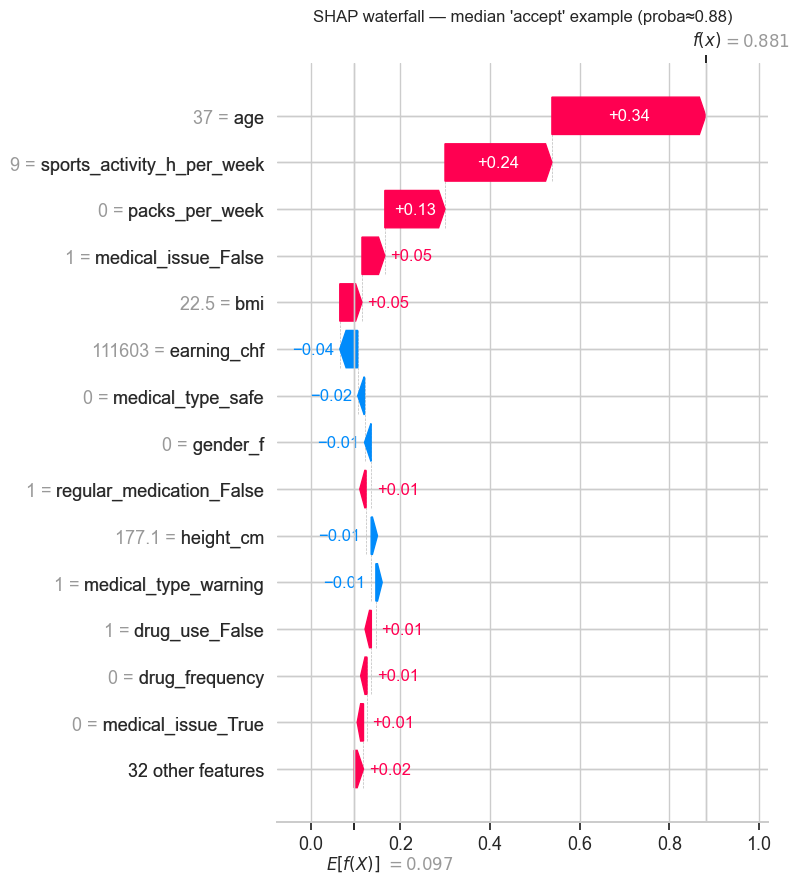

In [12]:
# Waterfall for an 'accept' example near median confidence
focus_cls = 'accept'
try:
    focus_idx = class_names.index(focus_cls)
except ValueError:
    focus_idx = 0
    focus_cls = class_names[0]

probs_all = xgb_model.predict_proba(X_test_t)
preds_idx = probs_all.argmax(axis=1)
mask_pred_focus = preds_idx == focus_idx

if mask_pred_focus.any():
    cand_idx = np.where(mask_pred_focus)[0]
    cand_probs = probs_all[cand_idx, focus_idx]
    target = np.median(cand_probs)
    pick_rel = int(np.argmin(np.abs(cand_probs - target)))
    pick = int(cand_idx[pick_rel])
else:
    # fallback: pick the overall median probability example
    target = np.median(probs_all[:, focus_idx])
    pick = int(np.argmin(np.abs(probs_all[:, focus_idx] - target)))

# Compute SHAP for this single example
shap_one = explainer(X_test_t[[pick]])
base_vals = getattr(shap_one, 'base_values', None)
if isinstance(base_vals, np.ndarray) and base_vals.ndim == 2:
    base_val = float(base_vals[0, focus_idx])
elif isinstance(base_vals, np.ndarray) and base_vals.ndim == 1:
    base_val = float(base_vals[0])
else:
    base_val = 0.0

vals = getattr(shap_one, 'values', shap_one)
if isinstance(vals, np.ndarray) and vals.ndim == 3:
    contrib = vals[0, :, focus_idx]
elif isinstance(vals, np.ndarray) and vals.ndim == 2:
    contrib = vals[0]
else:
    contrib = np.array(vals).reshape(-1)

x_one = X_test_t[pick]
exp_mid = shap.Explanation(values=contrib, base_values=base_val, data=x_one, feature_names=feat_names)

plt.figure(figsize=(9,7))
shap.plots.waterfall(exp_mid, max_display=15, show=False)
plt.title(f"SHAP waterfall — median '{focus_cls}' example (proba≈{probs_all[pick, focus_idx]:.2f})")
plt.tight_layout()
plt.show()


In [13]:
# Numeric summary for predicted probabilities of class 'accept'
focus_cls = 'accept'
try:
    focus_idx = class_names.index(focus_cls)
except ValueError:
    focus_idx = 0
    focus_cls = class_names[0]

probs_all = xgb_model.predict_proba(X_test_t)
p = probs_all[:, focus_idx]
q = np.quantile(p, [0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0])
mean = float(np.mean(p))
std = float(np.std(p))
share_pred_class = float((probs_all.argmax(axis=1) == focus_idx).mean())

print(f"Class: {focus_cls}")
print("quantiles [0, 5, 25, 50, 75, 95, 100]%:", [round(float(x), 3) for x in q])
print("mean:", round(mean, 3), "std:", round(std, 3))
print(f"share predicted as '{focus_cls}':", round(share_pred_class, 3))


Class: accept
quantiles [0, 5, 25, 50, 75, 95, 100]%: [0.0, 0.0, 0.0, 0.0, 0.006, 0.892, 0.986]
mean: 0.105 std: 0.258
share predicted as 'accept': 0.107


## Save inference artifacts for the backend

This will export the trained preprocessor, label encoder, feature names, and the XGBoost model, plus a small SHAP background sample, into `code/backend/data/model/` so the API can serve predictions.

In [14]:
# Export trained artifacts for serving
from pathlib import Path
import json, os, time
import numpy as np
import joblib
import xgboost as xgb

# Resolve repo root (this notebook lives in baselhacks_pax/datageneration/)
try:
    nb_dir = Path(__file__).parent
except NameError:
    nb_dir = Path.cwd()
repo_root = nb_dir.parent
model_dir = repo_root / 'code' / 'backend' / 'data' / 'model'
model_dir.mkdir(parents=True, exist_ok=True)

# 1) Save preprocessing pipeline and label encoder
joblib.dump(pre, model_dir / 'preprocessor.joblib')
joblib.dump(le, model_dir / 'label_encoder.joblib')

# 2) Save the XGBoost model (native Booster JSON)
model_json_path = model_dir / 'xgboost_model.json'
xgb_model.get_booster().save_model(str(model_json_path))

# 3) Save feature names and metadata for mapping at inference
feat_path = model_dir / 'feature_names.json'
with open(feat_path, 'w', encoding='utf-8') as f:
    json.dump({
        'numeric_cols': numeric_cols,
        'categorical_cols': categorical_cols,
        'onehot_feature_names': list(pre.named_transformers_['cat'].get_feature_names_out(categorical_cols)),
        'all_feature_names_after_pre': list(feat_names),
        'class_names': class_names,
    }, f, indent=2)

# 4) Save a small SHAP background sample for on-demand per-instance explanations
bg_size = min(200, X_train_t.shape[0])
rng = np.random.default_rng(42)
bg_idx = rng.choice(X_train_t.shape[0], size=bg_size, replace=False)
bg = X_train_t[bg_idx]
np.save(model_dir / 'shap_background.npy', bg)

# 5) Save a manifest for easy versioning in the API
manifest = {
    'model_type': 'xgboost.XGBClassifier',
    'objective': 'multi:softprob',
    'n_classes': int(len(class_names)),
    'class_names': class_names,
    'created_at': time.strftime('%Y-%m-%d %H:%M:%S'),
    'training_data': {
        'X_shape_train_t': list(map(int, X_train_t.shape)),
        'X_shape_valid_t': list(map(int, X_valid_t.shape)),
        'X_shape_test_t': list(map(int, X_test_t.shape)),
    },
    'feature_schema': {
        'numeric_cols': numeric_cols,
        'categorical_cols': categorical_cols,
    },
    'artifacts': {
        'preprocessor': 'preprocessor.joblib',
        'label_encoder': 'label_encoder.joblib',
        'model_json': 'xgboost_model.json',
        'feature_names': 'feature_names.json',
        'shap_background': 'shap_background.npy'
    }
}
with open(model_dir / 'manifest.json', 'w', encoding='utf-8') as f:
    json.dump(manifest, f, indent=2)

print('Artifacts saved to:', model_dir)

Artifacts saved to: c:\Users\mikej\OneDrive\Privat\Allgemein\HackathonBasel2025\baselhacks_pax\code\backend\data\model
